In [1]:
from PIL import Image, ImageDraw
import concurrent.futures
from skimage import metrics
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

Setting Hyperparameters

In [2]:
PADDING = 0 
OUTPUT_SCALE = 1
ERROR_THRESHOLD = 7

Defining Helper Functions

In [3]:
def display_images(original, compressed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')

    axs[1].imshow(compressed)
    axs[1].set_title('Compressed Image')

    for ax in axs:
        ax.axis('off')

    plt.show()

def process_image(image_path, max_depth=10):
    image = Image.open(image_path).convert('RGB')
    tree = Quadtree(image, max_depth=max_depth)
    compressed_image = tree.render_at_depth(max_depth)

    # Save the compressed image
    base_name = os.path.basename(image_path)
    base_name_without_ext = os.path.splitext(base_name)[0]
    compressed_image_path = f'./CompressedImages/{base_name_without_ext}_compressed.jpg'
    compressed_image.save(compressed_image_path)

    # Create and save the gif
    gif_path = f'./Gifs/{base_name_without_ext}_animation.gif'
    tree.create_gif(gif_path)

    return image, compressed_image

def calculate_metrics(original, compressed):
    original = np.array(original)
    compressed = np.array(compressed)
    psnr = metrics.peak_signal_noise_ratio(original, compressed)
    
    mse = metrics.mean_squared_error(original, compressed)
    return psnr, mse

def process_batch(image_paths, max_depth=10):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_image, path, max_depth) for path in image_paths]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    
    metrics = []
    for original, compressed in results:
        metrics.append(calculate_metrics(original, compressed))
        display_images(original, compressed)
        
    return metrics

def display_metrics(metrics):
    psnrs, mses = zip(*metrics)
    plt.figure(figsize=(10, 6))
    plt.plot(psnrs, label='PSNR')
    plt.plot(mses, label='MSE')
    plt.legend()
    plt.show()

def weighted_average(hist):
    total = sum(hist)
    value, error = 0, 0
    if total > 0:
        value = sum(i * x for i, x in enumerate(hist)) / total
        error = sum(x * (value - i) ** 2 for i, x in enumerate(hist)) / total
        error = error ** 0.5
    return value, error


def color_from_histogram(hist):
    r, re = weighted_average(hist[:256])
    g, ge = weighted_average(hist[256:512])
    b, be = weighted_average(hist[512:768])
    e = re * 0.2989 + ge * 0.5870 + be * 0.1140
    return (int(r), int(g), int(b)), e


Defining The QuadTree Node

In [4]:
class QuadtreeNode(object):

    def __init__(self, img, box, depth):
        self.box = box
        self.depth = depth
        self.children = None
        self.leaf = False

        image = img.crop(box)
        self.width, self.height = image.size
        hist = image.histogram()
        self.color, self.error = color_from_histogram(hist)

    def is_leaf(self):
        return self.leaf

    def split(self, img):
        l, t, r, b = self.box
        lr = l + (r - l) / 2
        tb = t + (b - t) / 2
        tl = QuadtreeNode(img, (l, t, lr, tb), self.depth+1)
        tr = QuadtreeNode(img, (lr, t, r, tb), self.depth+1)
        bl = QuadtreeNode(img, (l, tb, lr, b), self.depth+1)
        br = QuadtreeNode(img, (lr, tb, r, b), self.depth+1)
        self.children = [tl, tr, bl, br]

    def to_image(self, x=0, y=0, img=None):
        if img is None:
            img = Image.new('RGB', (self.width, self.height))

        if self.children is None:
            # If this is a leaf node, fill the corresponding area of the image with the node's color
            for i in range(x, x + self.width):
                for j in range(y, y + self.height):
                    img.putpixel((i, j), self.color)
        else:
            # If this is an internal node, process each of the children
            half_width = self.width // 2
            half_height = self.height // 2
            self.children[0].to_image(x, y, img)
            self.children[1].to_image(x + half_width, y, img)
            self.children[2].to_image(x, y + half_height, img)
            self.children[3].to_image(x + half_width, y + half_height, img)

        return img

Defining the Quadtree Class

In [5]:
class Quadtree(object):

    def __init__(self, image, max_depth=1024):
        self.root = QuadtreeNode(image, image.getbbox(), 0)
        self.width, self.height = image.size
        self.max_depth = 0

        self._build_tree(image, self.root, max_depth)

    def _build_tree(self, image, node, max_depth):
        if (node.depth >= max_depth) or (node.error <= ERROR_THRESHOLD):
            if node.depth > self.max_depth:
                self.max_depth = node.depth
            node.leaf = True
            return

        node.split(image)
        for child in node.children:
            self._build_tree(image, child, max_depth)

    def get_leaf_nodes(self, depth):
        def get_leaf_nodes_recusion(tree, node, depth, func):
            if node.leaf is True or node.depth == depth:
                func(node)
            elif node.children is not None:
                for child in node.children:
                    get_leaf_nodes_recusion(tree, child, depth, func)

        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        leaf_nodes = []
        get_leaf_nodes_recusion(self, self.root, depth, leaf_nodes.append)
        return leaf_nodes

    def _create_image_from_depth(self, depth):
        m = OUTPUT_SCALE
        dx, dy = (PADDING, PADDING)
        image = Image.new('RGB', (int(self.width * m + dx),
                                  int(self.height * m + dy)))
        draw = ImageDraw.Draw(image)
        draw.rectangle((0, 0, self.width * m + dx,
                        self.height * m + dy), (0, 0, 0))

        leaf_nodes = self.get_leaf_nodes(depth)
        for node in leaf_nodes:
            l, t, r, b = node.box
            box = (l * m + dx, t * m + dy, r * m - 1, b * m - 1)
            draw.rectangle(box, node.color)
        return image

    def render_at_depth(self, depth=0):
        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        image = self._create_image_from_depth(depth)
        return image

    def create_gif(self, file_name, duration=1000, loop=0):
        images = []
        end_product_image = self._create_image_from_depth(self.max_depth)
        for i in range(self.max_depth):
            image = self._create_image_from_depth(i)
            images.append(image)
        for _ in range(4):
            images.append(end_product_image)
        images[0].save(
            file_name,
            save_all=True,
            append_images=images[1:],
            duration=duration, loop=loop)
    
    def calculate_size(self):
        def calculate_size_recursion(node):
            size = 1 
            if node.children is not None:
                for child in node.children:
                    size += calculate_size_recursion(child)
            return size

        return calculate_size_recursion(self.root)

    def compression_ratio(self):
        input_size = self.width * self.height * 3
        output_size = self.calculate_size() * 24
        compression_ratio = input_size / output_size

        return compression_ratio
    
    def to_image(self):
        return self.root.to_image()

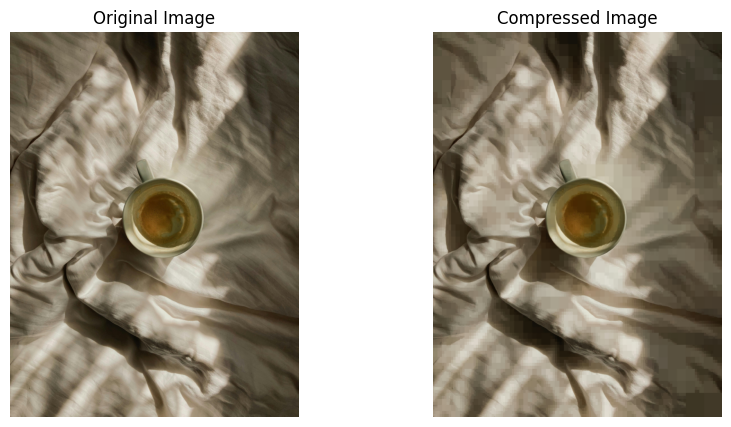

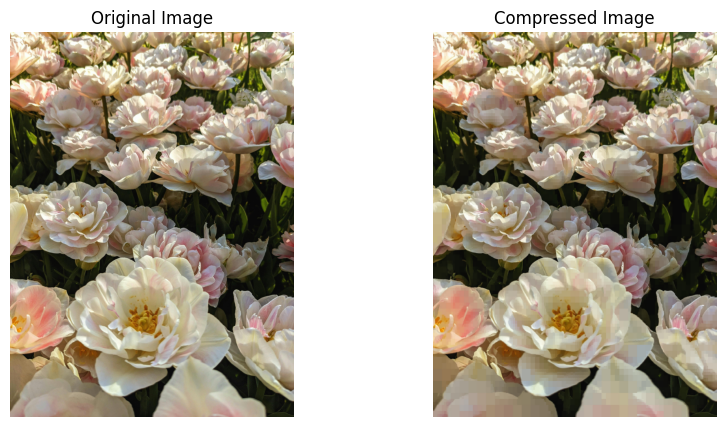

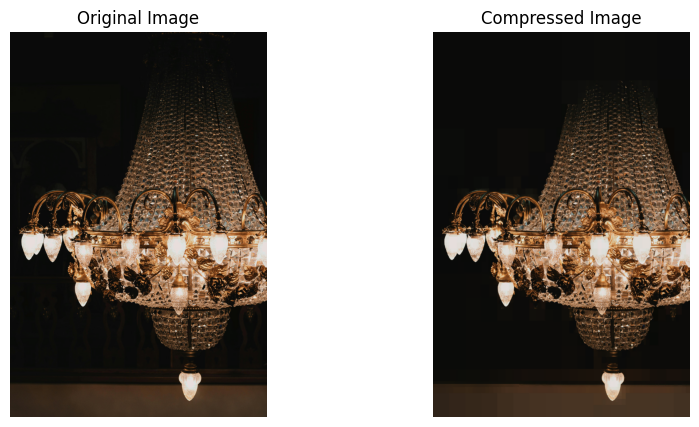

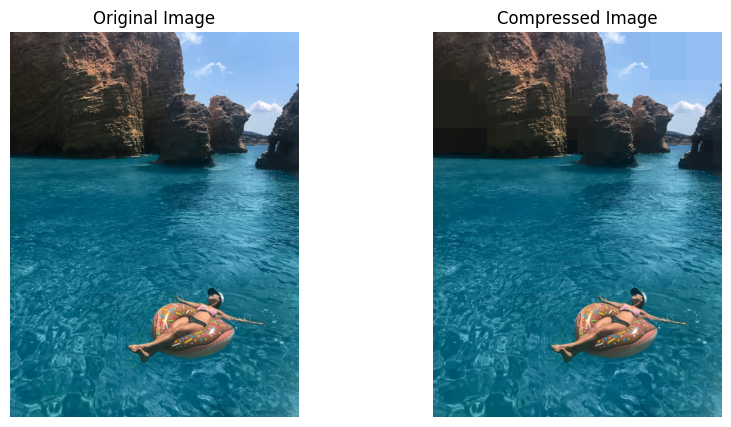

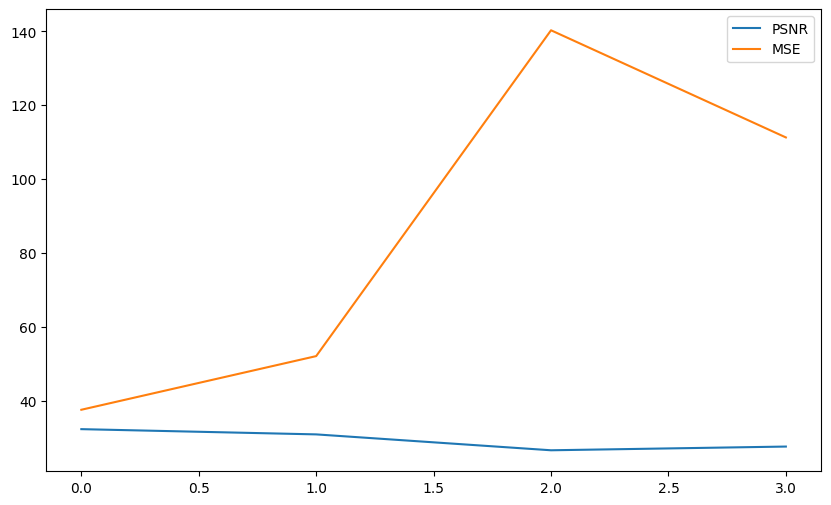

In [6]:
image_paths = glob.glob('./Images/*.jpg')
metrics = process_batch(image_paths, max_depth=10)
display_metrics(metrics)